# Face Recognition with ResNet50 Transfer Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EhsanulHaqueSiam/CVPR/blob/main/FINAL/FaceRecognition.ipynb)
[![View on GitHub](https://img.shields.io/badge/GitHub-View_Source-181717?logo=github)](https://github.com/EhsanulHaqueSiam/CVPR/blob/main/FINAL/FaceRecognition.ipynb)


---

**Description:** Advanced face recognition using ResNet50 transfer learning with ImageNet weights. Two-phase training (frozen → fine-tuned) for high accuracy.

**Author:** Ehsanul Haque Siam


In [10]:
"""
Face Recognition Attendance - ResNet50 Transfer Learning
Simple notebook-style code
"""

'\nFace Recognition Attendance - ResNet50 Transfer Learning\nSimple notebook-style code\n'

In [11]:
!pip install tensorflow opencv-python numpy==1.26.4 matplotlib seaborn scikit-learn gdown -q

In [12]:
# Cell: Download Dataset from Google Drive
import gdown
import os

# Google Drive file ID
FILE_ID = "1c6c6Ogw82xNSON6sDtwdXv2VMI1-C4uD"
OUTPUT_FILE = "preprocessed_faces.npz"

if not os.path.exists(OUTPUT_FILE):
    print("Downloading dataset from Google Drive...")
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, OUTPUT_FILE, quiet=False)
    print(f"✓ Downloaded: {OUTPUT_FILE}")
else:
    print(f"✓ Dataset already exists: {OUTPUT_FILE}")

✓ Dataset already exists: preprocessed_faces.npz


In [13]:
# Cell 1: Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import csv

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [14]:
# Cell 2: Configuration
IMG_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 120
MIN_CONFIDENCE = 0.85  # 85% threshold to reduce false positives

# ========== LOAD MODEL ONLY MODE ==========
# Set to True to skip training and use saved model
LOAD_MODEL_ONLY = False  # Change to True after training once
# ==========================================

BASE_DIR = Path(__file__).parent.absolute() if '__file__' in dir() else Path('.').absolute()
MODEL_DIR = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True)
SAVED_MODEL_PATH = MODEL_DIR / 'resnet50_model.keras'

print("=" * 50)
print("Face Recognition - ResNet50 Transfer Learning")
print(f"LOAD_MODEL_ONLY = {LOAD_MODEL_ONLY}")
print("=" * 50)

Face Recognition - ResNet50 Transfer Learning
LOAD_MODEL_ONLY = False


In [15]:
# Cell 3: Load Data from NPZ
print("\nLoading data...")
data = np.load(BASE_DIR / 'preprocessed_faces.npz', allow_pickle=True)
X_raw = data['X']
y = data['y']
CLASS_NAMES = list(data['class_names'])
NUM_CLASSES = len(CLASS_NAMES)

# Resize to model input size
X = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_raw], dtype=np.float32)
print(f"✓ Loaded {len(X)} images, {NUM_CLASSES} classes")


Loading data...
✓ Loaded 1319 images, 66 classes


In [16]:
# Cell 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Apply ResNet preprocessing
X_train_processed = preprocess_input(X_train.copy())
X_test_processed = preprocess_input(X_test.copy())

Train: 1055, Test: 264


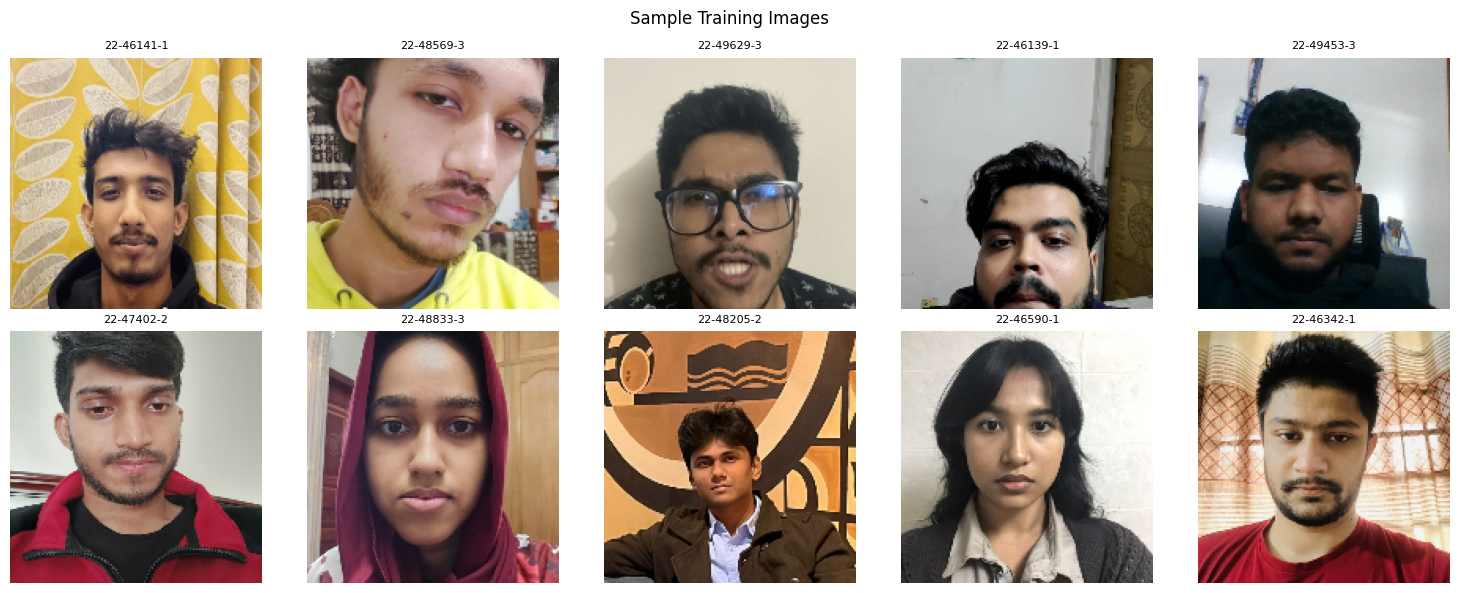

In [17]:
# Cell 5: Sample Images
plt.figure(figsize=(15, 6))
for i in range(min(10, len(X_train))):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].astype(np.uint8))
    plt.title(CLASS_NAMES[y_train[i]][:12], fontsize=8)
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_images.png')
plt.show()

In [18]:
# Cell 6: Build or Load Model
if LOAD_MODEL_ONLY and SAVED_MODEL_PATH.exists():
    print(f"\n✓ Loading saved model: {SAVED_MODEL_PATH}")
    model = keras.models.load_model(SAVED_MODEL_PATH)
    base_model = None  # Not needed when loading
    print("✓ Model loaded successfully!")
else:
    print("\nBuilding ResNet50 model...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base
    
    model = models.Sequential([
        layers.Resizing(224, 224),
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()


Building ResNet50 model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)


Phase 1: Training with frozen ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0589 - loss: 4.5518 - val_accuracy: 0.2841 - val_loss: 3.2121 - learning_rate: 0.0010
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.2406 - loss: 3.1755 - val_accuracy: 0.5871 - val_loss: 1.9388 - learning_rate: 0.0010
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3863 - loss: 2.3938 - val_accuracy: 0.7273 - val_loss: 1.1522 - learning_rate: 0.0010
Epoch 4/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5611 - loss: 1.6893 - val_accuracy: 0.7311 - val_loss: 1.0159 - learning_rate: 0.0010
Epoch 5/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5924 - loss: 1.5079 - val_accuracy: 0.8220 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 6/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6306 - loss: 1.3110 - val_accuracy: 0.8258 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 7/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7024 - loss: 0.9800 - val_accuracy: 

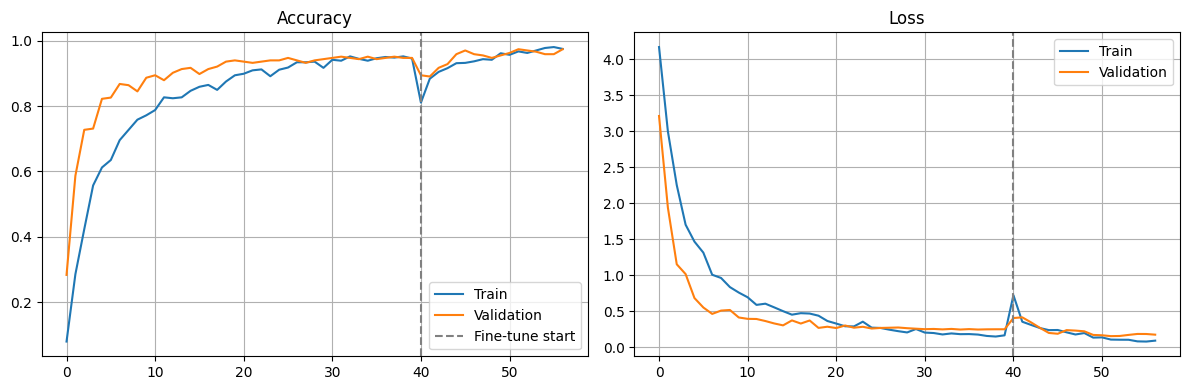

In [19]:
# Cell 7-10: Training (skipped if LOAD_MODEL_ONLY=True)
if not LOAD_MODEL_ONLY:
    # Data Augmentation (TRAIN ONLY)
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
    
    # Phase 1 - Train with Frozen Base
    print("\n" + "=" * 50)
    print("Phase 1: Training with frozen ResNet50...")
    print("=" * 50)
    
    history1 = model.fit(
        train_datagen.flow(X_train_processed, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS // 2,
        validation_data=(X_test_processed, y_test_cat),
        callbacks=callbacks
    )
    
    # Phase 2 - Fine-tune
    print("\n" + "=" * 50)
    print("Phase 2: Fine-tuning...")
    print("=" * 50)
    
    base_model.trainable = True
    for layer in base_model.layers[:50]:
        layer.trainable = False
    
    model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history2 = model.fit(
        train_datagen.flow(X_train_processed, y_train_cat, batch_size=BATCH_SIZE),
        epochs=EPOCHS // 2,
        validation_data=(X_test_processed, y_test_cat),
        callbacks=callbacks
    )
    
    model.save(SAVED_MODEL_PATH)
    print(f"\n✓ Model saved to: {SAVED_MODEL_PATH}")
    
    # Training History
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    axes[0].plot(acc, label='Train')
    axes[0].plot(val_acc, label='Validation')
    axes[0].axvline(len(history1.history['accuracy']), color='gray', linestyle='--', label='Fine-tune start')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(loss, label='Train')
    axes[1].plot(val_loss, label='Validation')
    axes[1].axvline(len(history1.history['loss']), color='gray', linestyle='--')
    axes[1].set_title('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(MODEL_DIR / 'training_history.png')
    plt.show()
else:
    print("\n✓ LOAD_MODEL_ONLY=True: Skipping training, using saved model")

In [20]:
# Cell 11: Evaluation
loss, accuracy = model.evaluate(X_test_processed, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy:.1%}")

y_pred = np.argmax(model.predict(X_test_processed, verbose=0), axis=1)
y_pred_conf = np.max(model.predict(X_test_processed, verbose=0), axis=1)

high_conf_mask = y_pred_conf >= MIN_CONFIDENCE
if high_conf_mask.sum() > 0:
    high_conf_acc = (y_pred[high_conf_mask] == y_test[high_conf_mask]).mean()
    print(f"High Confidence Accuracy: {high_conf_acc:.1%}")


Test Accuracy: 97.3%
High Confidence Accuracy: 98.8%


In [21]:
# Cell 12: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

  21-45902-3       1.00      1.00      1.00         4
  22-46138-1       1.00      1.00      1.00         4
  22-46139-1       1.00      1.00      1.00         4
  22-46141-1       1.00      1.00      1.00         4
  22-46275-1       1.00      1.00      1.00         4
  22-46293-1       1.00      1.00      1.00         4
  22-46342-1       1.00      1.00      1.00         4
  22-46473-1       1.00      1.00      1.00         4
  22-46536-1       1.00      1.00      1.00         4
  22-46590-1       1.00      1.00      1.00         4
  22-46666-1       1.00      1.00      1.00         4
  22-46679-1       1.00      1.00      1.00         4
  22-46887-1       1.00      1.00      1.00         4
  22-46945-1       1.00      1.00      1.00         4
  22-46983-1       1.00      1.00      1.00         4
  22-47180-1       1.00      1.00      1.00         4
  22-47294-1       0.67      0.50      0.57         4
  2

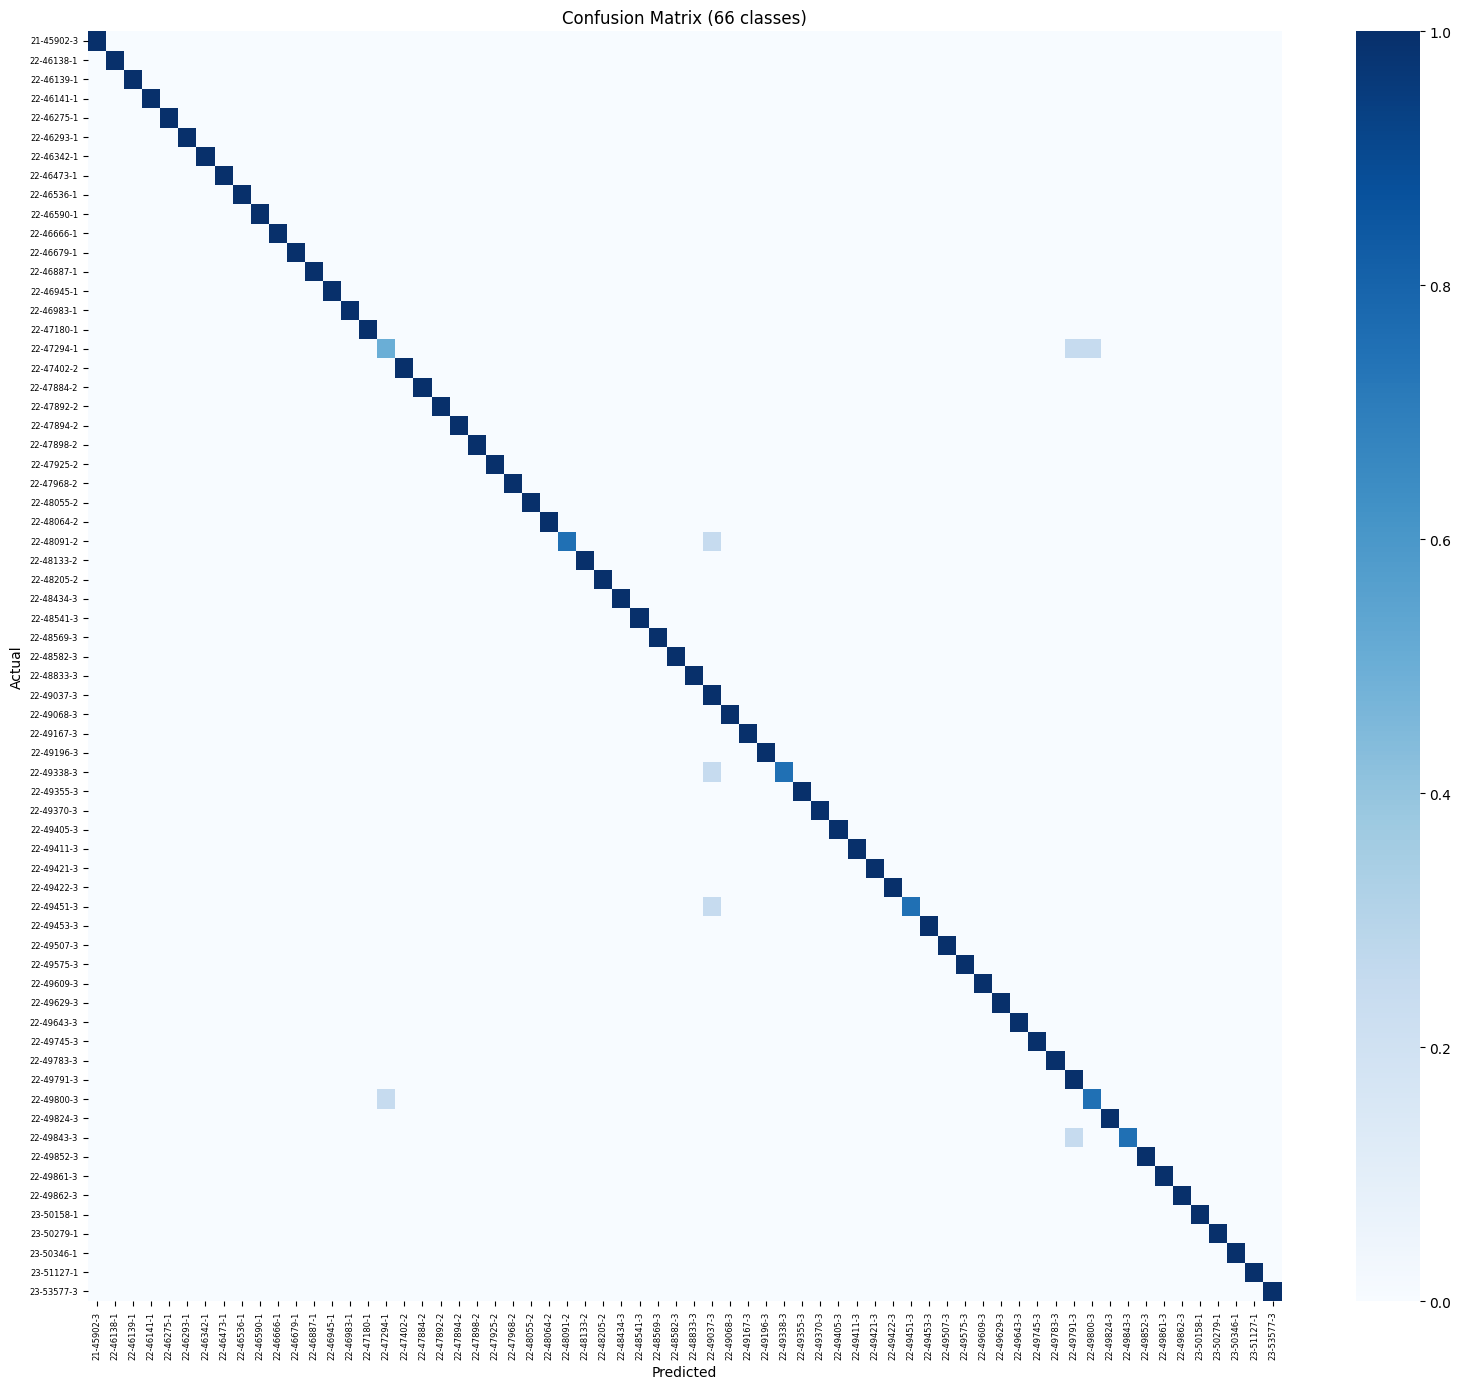

In [22]:
# Cell 13: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=False, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix ({NUM_CLASSES} classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=150)
plt.show()

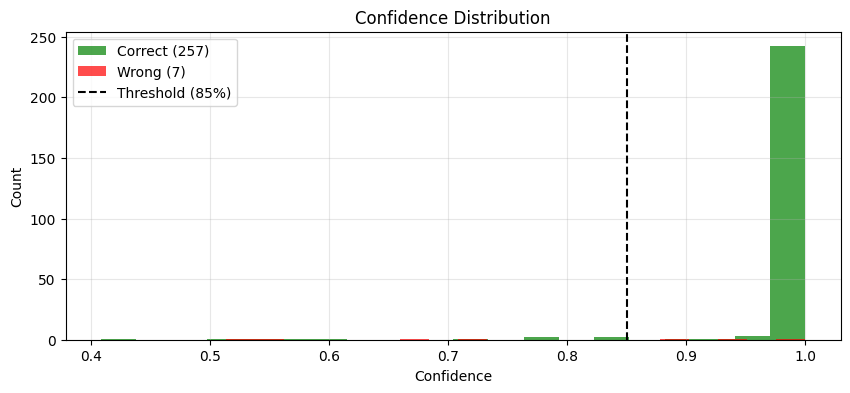

In [23]:
# Cell 14: Confidence Distribution
plt.figure(figsize=(10, 4))
correct = y_pred == y_test
plt.hist(y_pred_conf[correct], bins=20, alpha=0.7, label=f'Correct ({correct.sum()})', color='green')
plt.hist(y_pred_conf[~correct], bins=20, alpha=0.7, label=f'Wrong ({(~correct).sum()})', color='red')
plt.axvline(MIN_CONFIDENCE, color='black', linestyle='--', label=f'Threshold ({MIN_CONFIDENCE:.0%})')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(MODEL_DIR / 'confidence_distribution.png')
plt.show()

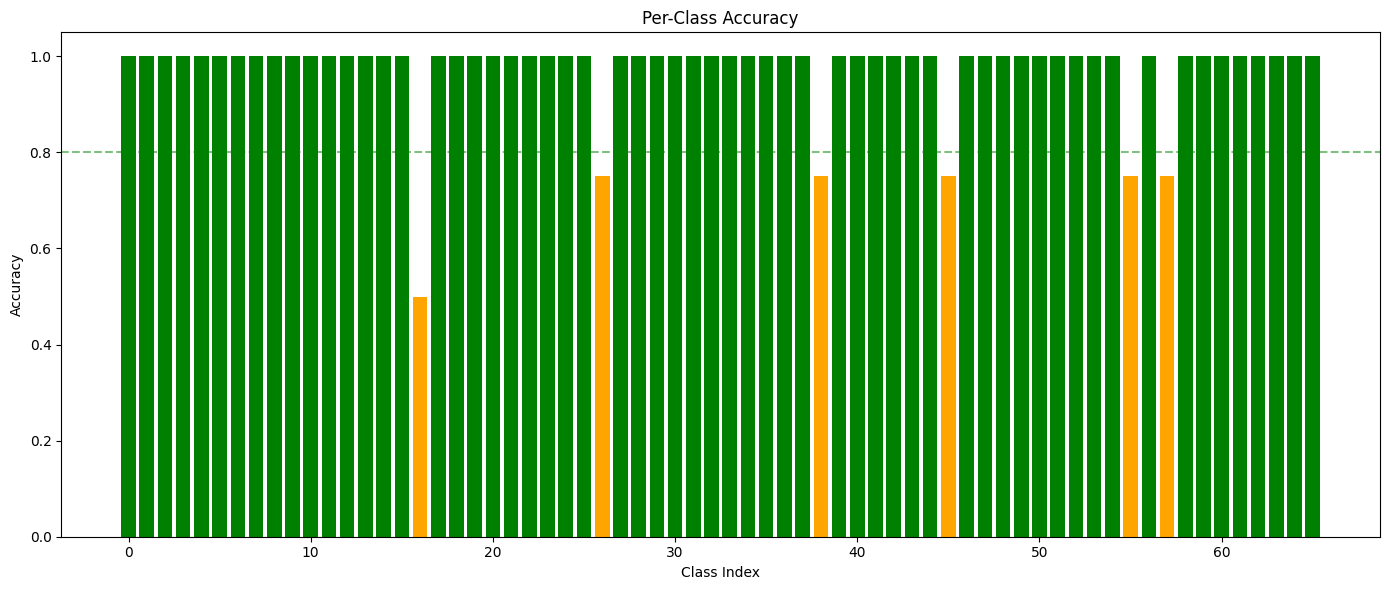

In [24]:
# Cell 15: Per-Class Accuracy
per_class_acc = []
for i in range(NUM_CLASSES):
    mask = y_test == i
    if mask.sum() > 0:
        per_class_acc.append((y_pred[mask] == i).mean())
    else:
        per_class_acc.append(0)

plt.figure(figsize=(14, 6))
colors = ['green' if a >= 0.8 else 'orange' if a >= 0.5 else 'red' for a in per_class_acc]
plt.bar(range(NUM_CLASSES), per_class_acc, color=colors)
plt.axhline(0.8, color='green', linestyle='--', alpha=0.5)
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'per_class_accuracy.png')
plt.show()

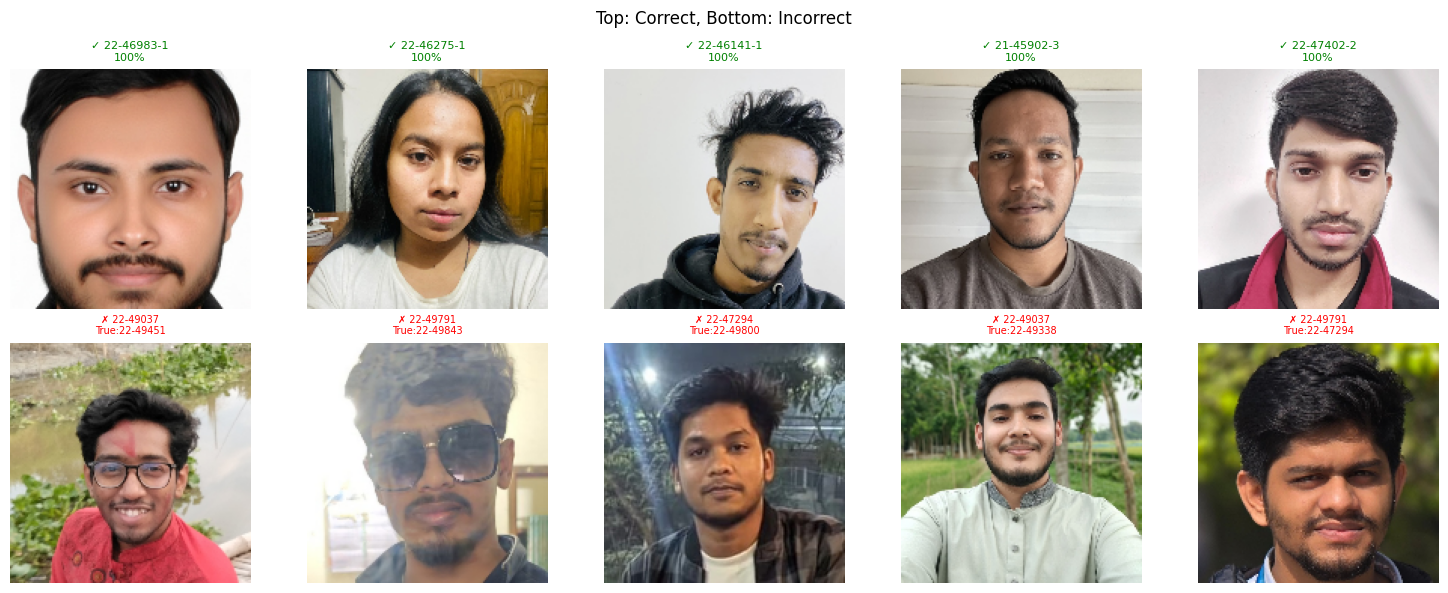

In [25]:
# Cell 16: Sample Predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
correct_idx = np.where(correct)[0][:5]
wrong_idx = np.where(~correct)[0][:5]

for i, idx in enumerate(correct_idx):
    axes[0, i].imshow(X_test[idx].astype(np.uint8))
    axes[0, i].set_title(f'✓ {CLASS_NAMES[y_test[idx]][:10]}\n{y_pred_conf[idx]:.0%}', color='green', fontsize=8)
    axes[0, i].axis('off')

for i in range(5):
    if i < len(wrong_idx):
        idx = wrong_idx[i]
        axes[1, i].imshow(X_test[idx].astype(np.uint8))
        axes[1, i].set_title(f'✗ {CLASS_NAMES[y_pred[idx]][:8]}\nTrue:{CLASS_NAMES[y_test[idx]][:8]}', color='red', fontsize=7)
    axes[1, i].axis('off')

plt.suptitle('Top: Correct, Bottom: Incorrect')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'sample_predictions.png')
plt.show()

In [26]:
# Cell 17: Camera Attendance with Haar Cascade
print("\n" + "=" * 50)
print("CAMERA ATTENDANCE (ResNet50)")
print("Press 'q' to quit")
print("=" * 50)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
attendance = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detect ALL faces
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Crop face with margin
        margin = 0.1
        x1, y1 = max(0, int(x - w*margin)), max(0, int(y - h*margin))
        x2, y2 = min(frame.shape[1], int(x + w + w*margin)), min(frame.shape[0], int(y + h + h*margin))
        face = frame[y1:y2, x1:x2]
        
        # Preprocess for ResNet
        face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32)
        face = preprocess_input(face)
        
        # Predict
        pred = model.predict(np.expand_dims(face, 0), verbose=0)[0]
        idx, conf = np.argmax(pred), np.max(pred)
        name = CLASS_NAMES[idx] if conf >= MIN_CONFIDENCE else f"Unknown ({CLASS_NAMES[idx]}?)"
        
        # Mark attendance
        if conf >= MIN_CONFIDENCE and name not in attendance:
            attendance[name] = datetime.now()
            print(f"✓ {name} present ({conf:.0%})")
        
        # Draw
        color = (0, 255, 0) if conf >= MIN_CONFIDENCE else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, f"{name}: {conf:.0%}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    cv2.putText(frame, f"Present: {len(attendance)}/{NUM_CLASSES}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.imshow('Attendance', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print(f"\nTotal: {len(attendance)}/{NUM_CLASSES} present")


CAMERA ATTENDANCE (ResNet50)
Press 'q' to quit

Total: 0/66 present


[ WARN:0@6259.984] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@6259.984] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
